In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os 
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import cv2

# Constants

In [158]:
#Fill out these values with the appropiate paths to your datasets
CSV_PATH = r""
TEST_LIST_PATH =r""
TRAIN_VAL_LIST_PATH=r""
IMAGE_PATH =r""
MODEL_PATH = r"" #Only needed if you wanted to save your model

In [3]:
columns = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
          "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
          "Fibrosis", "Pleural_Thickening", "Hernia"]
n_classes = len(columns)
batch_size = 16

# Construction and Cleaning of Datasets

In [4]:
temp_df = pd.read_csv(CSV_PATH, usecols= ["Image Index", "Finding Labels", "Patient ID"])
temp_df.head()

,Image Index,Finding Labels,Patient ID
0,00000001_000.png,Cardiomegaly,1
1,00000001_001.png,Cardiomegaly|Emphysema,1
2,00000001_002.png,Cardiomegaly|Effusion,1
3,00000002_000.png,No Finding,2
4,00000003_001.png,Hernia,3


In [5]:
# Move the data to a label_df which will only containt findings that we are searching for
num_indexes = len(temp_df["Image Index"])
label_df = pd.DataFrame(0, index= temp_df["Image Index"], columns = columns)
label_df["Patient ID"] = temp_df["Patient ID"].to_numpy()
for i in range(num_indexes):
    split_findings=  temp_df["Finding Labels"][i].split("|")
    for finding in split_findings:
        if finding in columns:
            label_df[finding][i]=1

label_df.head()

,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,Patient ID
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
00000003_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [6]:
with open(TRAIN_VAL_LIST_PATH) as f:
    train_val_list = [line.rstrip('\n') for line in f]
with open(TEST_LIST_PATH) as f:
    test_list = [line.rstrip('\n') for line in f]

In [7]:
train_val_df = label_df.drop(test_list)
test_df = label_df.drop(train_val_list)
train_df, val_df = train_test_split(train_val_df, test_size = .25, random_state=42)
train_df.head()

,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,Patient ID
Image Index,,,,,,,,,,,,,,,
00025848_000.png,0,0,1,0,1,1,0,0,0,0,0,0,0,0,25848
00015852_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,15852
00005448_006.png,0,0,1,0,0,0,0,0,0,0,0,0,1,0,5448
00006150_004.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6150
00012177_004.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12177


# Problem: Data Leakage
An issue with many medical datasets is that of data leakage. If patients who are present within the training set are also in the validation and testset and can make the model seem more effective than it really is since it has "seen" that patient before and therefore will have a better guess about what its labels should be. To solve this we will remove all overlap between train/validation and train/test. All of overlapped samples inside validation and test sets wil be placed inside the training set.

In [8]:
def pat_overlap(df1, df2, patient_col):
    """
    Function to look for data leakage between dataframes
        Args:
            df1 (dataframe): Containing patient ID info
            df2 (dataframe): Containing patient ID info
            patient_col (str): Name of df col with patient ID's
        Returns:
            overlap (list): List of patients that are present in both df's
    """
    set1= set(list(df1[patient_col]))
    set2= set(list(df2[patient_col]))

    overlap = list(set1.intersection(set2))
    
    return overlap
    

In [9]:
# Check to see if there is data leakage between train, val, and test datasets
# Overlapping patients are sent to the train set and removed from val and test set
train_val_overlap = pat_overlap(train_df, val_df, "Patient ID")

if len(train_val_overlap) != 0:
    overlap_df = val_df[val_df['Patient ID'].isin(train_val_overlap)]
    train_df = pd.concat([train_df, overlap_df])
    val_df = val_df.drop(overlap_df.index)

train_test_overlap = pat_overlap(train_df, test_df, "Patient ID")

if len(train_test_overlap) != 0:
    overlap_df = test_df[test_df['Patient ID'].isin(train_test_overlap)]
    train_df = pd.concat([train_df, overlap_df])
    test_df = test_df.drop(overlap_df.index)

In [10]:
train_df = train_df.drop(["Patient ID"], axis = 1)
val_df = val_df.drop(["Patient ID"], axis = 1)
test_df = test_df.drop(["Patient ID"], axis = 1)

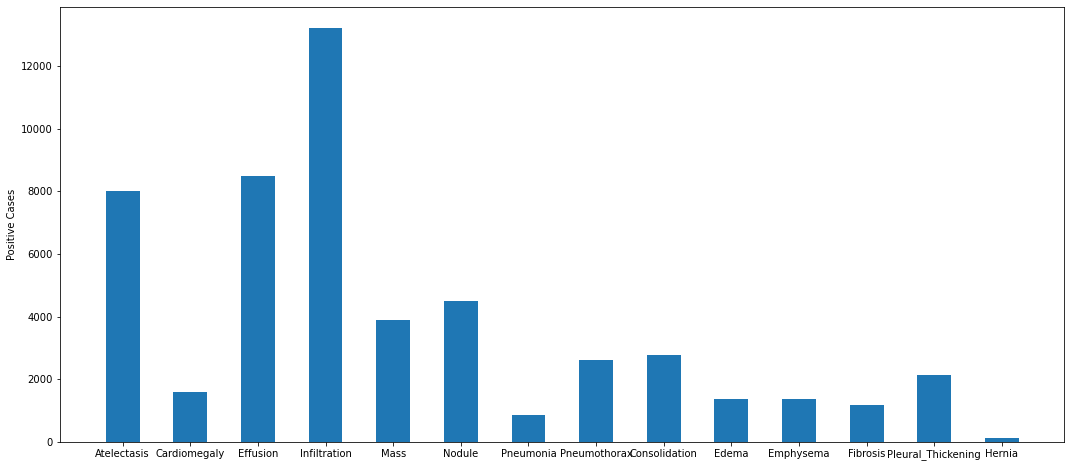

In [11]:
pos_counts=[]
for col in columns:
    pos_counts.append(np.count_nonzero(train_df[col]))
plt.figure(figsize=[18,8])
plt.bar(columns, pos_counts, width=0.5, align='center')
plt.ylabel("Positive Cases")
plt.show()

# Problem: Unbalanced Dataset
As you can see from the data this is nowhere close to a balanced dataset. Therefore we must increase the importance of a positive prediction in order for our model to not just shunt all predictions to 0 in order to decrease its loss. We will then implement the weighted binary loss function from the ChexNet paper in the get_weighted_loss function below

In [12]:
# In order for the model to not just output 0 for classes such as hernia we must increase the weight for a positive case 
pos_freqs = (np.array(pos_counts))/len(train_df)
neg_freqs = 1 -pos_freqs
pos_weights = neg_freqs
neg_weights = pos_freqs

In [13]:
pos_weights

array([0.90221332, 0.98057695, 0.89620695, 0.83860926, 0.95235189,
       0.94503925, 0.98961093, 0.96811251, 0.96596389, 0.98328715,
       0.98312844, 0.98580201, 0.97391134, 0.99841295])

In [14]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        e  = np.ones([len(pos_weights),1])*epsilon
        y_true = K.cast(y_true, "float32")
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            y_pred_i = y_pred[:,i]
            y_true_i = y_true[:,i]
            loss += -K.mean(pos_weights[i]*y_true_i*K.log(y_pred_i+e)+neg_weights[i]*(1-y_true_i)*(K.log(1-y_pred_i+e))) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

# Create Image Data Pipeline

In [16]:
def get_train_generator(train_df, directory, x_col, y_col, targ_x = 320, targ_y = 320,
                       batch_size =16, seed = 42):
    """
    Returns a generator to be used for training (not validation/testing)
    Args:
        train_df (dataframe)
        directory (str): directory that contains the images
        x_col (str): column name that that contains the filenames
        y_col (list): list of columns containing the true labels 
        targ_x (int): x dimension for target image
        targ_y (int): y dimension for target image
        batch_size (int)
        seed (int): The random seed 
    Returns:
        train_generator (DataFrameIterator)
    """
    print("getting train generator...")
    train_df[x_col] = train_df.index #DataFrame needs a column for labels not a df index
    
    image_generator = image.ImageDataGenerator( 
        samplewise_center=True,
        samplewise_std_normalization = True,
        horizontal_flip = True)
    
    train_generator = image_generator.flow_from_dataframe(train_df, directory,
                        x_col = x_col, y_col=y_col, target_size =(targ_x, targ_y),
                        class_mode ="raw", batch_size = batch_size, shuffle = True, seed = seed)
    
    return train_generator
    

In [130]:
def get_val_test_generator(val_df, test_df, train_df, directory,  x_col, y_col, targ_x = 320, targ_y = 320,
                       batch_size =16, sample_size = 100, seed = 42):
    """
    Returns generators for validation and test set data, first it compute statisitcs from the 
    training set data to use for normalizing validation and test data
    Args:
        val_df, test_df, train_df (dataframe)
        directory (str): directory that contains the images
        x_col (str): column name that that contains the filenames
        y_col (list): list of columns containing the true labels 
        targ_x (int): x dimension for target image
        targ_y (int): y dimension for target image
        batch_size (int)
        sample_size (int): batch size to be used for generating training statistics
        seed (int): The random seed
        
    Returns:
        test_generator and valid_generator (dataframe)
    """
    print("Computing training statistics..")
    raw_train_generator = image.ImageDataGenerator().flow_from_dataframe(train_df, directory,
                        x_col = x_col, y_col=y_col, target_size =(targ_x, targ_y),
                        class_mode ="raw", batch_size = sample_size, shuffle = True, seed = seed)
    
    batch = raw_train_generator.next()
    data_sample = batch[0]
    # use sample to fit mean and std for test set generator
    image_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
    print("Getting validation and test generators")
    val_df[x_col] = val_df.index
    test_df[x_col] = test_df.index
    valid_generator = image_generator.flow_from_dataframe(val_df, directory,
                        x_col = x_col, y_col=y_col, target_size =(targ_x, targ_y),
                        class_mode ="raw", batch_size = batch_size, shuffle = False, seed = seed)

    test_generator = image_generator.flow_from_dataframe(test_df, directory,
                        x_col = x_col, y_col=y_col, target_size =(targ_x, targ_y),
                        class_mode ="raw", batch_size = batch_size, shuffle = False, seed = seed)
    
    return valid_generator, test_generator


In [18]:
train_generator= get_train_generator(train_df, IMAGE_PATH, "Image Index", columns, batch_size = batch_size)
valid_generator, test_generator = get_val_test_generator(val_df, test_df, train_df, IMAGE_PATH, "Image Index", columns, batch_size = batch_size)

getting train generator...
Found 81913 validated image filenames.
Computing training statistics..
Found 81913 validated image filenames.
Getting validation and test generators
Found 4611 validated image filenames.
Found 25596 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


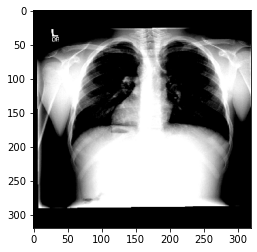

In [19]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

# Model Selection for Transfer Learning

In [21]:
base_model = tf.keras.applications.DenseNet121(include_top = False,
                                             weights = "imagenet",
                                             input_shape =(320, 320, 3))
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation = "sigmoid")(avg)
model= keras.models.Model(inputs = base_model.input, outputs = output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss= get_weighted_loss(pos_weights, neg_weights)

'base_model = tf.keras.applications.DenseNet121(include_top = False,\n                                             weights = "imagenet",\n                                             input_shape =(320, 320, 3))\navg=keras.layers.GlobalAveragePooling2D()(base_model.output)\noutput = keras.layers.Dense(n_classes, activation = "sigmoid")(avg)\nmodel= keras.models.Model(inputs = base_model.input, outputs = output)\noptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)\nloss= get_weighted_loss(pos_weights, neg_weights)'

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [23]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer = optimizer, loss= loss)
history = model.fit(train_generator, validation_data = valid_generator,
                   steps_per_epoch = len(train_df)//batch_size,
                   validation_steps = len(val_df)//batch_size,
                   epochs = 2)

'for layer in base_model.layers:\n    layer.trainable = False\nmodel.compile(optimizer = optimizer, loss= loss)\nhistory = model.fit(train_generator, validation_data = valid_generator,\n                   steps_per_epoch = len(train_df)//batch_size,\n                   validation_steps = len(val_df)//batch_size,\n                   epochs = 2)'

In [24]:
for layer in base_model.layers:
    layer.trainable = True
callback_1 = keras.callbacks.EarlyStopping(monitor = "loss", min_delta = .01,
                                            patience = 2)
callback_2 = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 1,
                                             mode = "min", verbose =1, min_delta=.005)

model.compile(optimizer = optimizer, loss= loss)
history = model.fit(train_generator, validation_data = valid_generator,
                   steps_per_epoch = len(train_df)//batch_size,
                   validation_steps = len(val_df)//batch_size,
                   epochs = 15, callbacks = [callback_1, callback_2])

'for layer in base_model.layers:\n    layer.trainable = True\ncallback_1 = keras.callbacks.EarlyStopping(monitor = "loss", min_delta = .01,\n                                            patience = 2)\ncallback_2 = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 1,\n                                             mode = "min", verbose =1, min_delta=.005)\n\nmodel.compile(optimizer = optimizer, loss= loss)\nhistory = model.fit(train_generator, validation_data = valid_generator,\n                   steps_per_epoch = len(train_df)//batch_size,\n                   validation_steps = len(val_df)//batch_size,\n                   epochs = 15, callbacks = [callback_1, callback_2])'

# Using ROC as a Measure of Effectiveness
The ROC curve is a way to measure a models ability to both be both sensitive enough to make a correct POSITIVE predictions while also being specific enough to make correct NEGATIVE predictions. A simple and easy way to tell how effective the model is is to see how far up into the left each curve is as well as the area underneath that curve. The closer to the corner, as well as the more area underneath the curve the better. 

In [25]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [26]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

Instructions for updating:
Please use Model.predict, which supports generators.


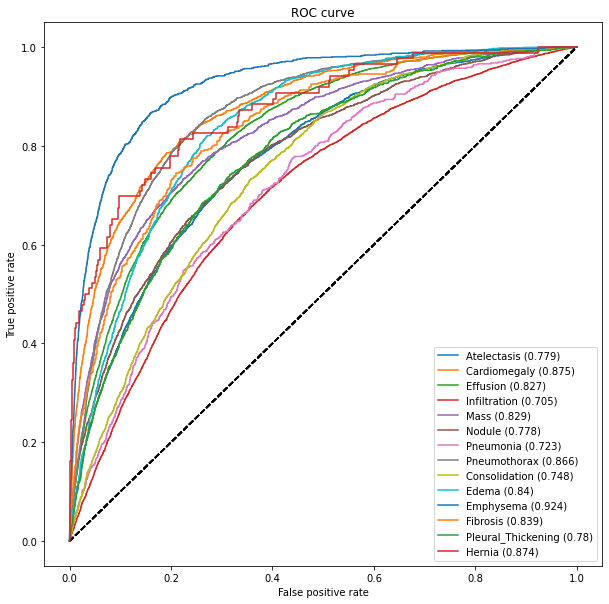

In [27]:
auc_rocs = get_roc_curve(columns, predicted_vals, test_generator)

# Grad_Cam for Localization of the Networks Predictions  
This is taken from a gradcam tutorial written by François Chollet, it has been slightly adjusted to fit into the specific needs of our project. The article can be found here: https://keras.io/examples/vision/grad_cam/

In [134]:
def load_preprocess(df, image_name, direc = IMAGE_PATH,  H=320, W=320):
    path = os.path.join(direc, image_name)
    img = image.load_img(path, target_size = (H, W))
    
    #Get Mean and Std_dev from 100 samples from the dataframe
    sample_list = []
    samples = label_df.sample(n=100, axis=0).index
    for i in samples:
        path = os.path.join(direc, i)
        sample_list.append(np.array(image.load_img(path, target_size = (H, W))))
    
    mean = np.mean(sample_list)
    std = np.std(sample_list)
    
    img = image.img_to_array(img)
    img = img - mean
    img = img/std
    img = np.expand_dims(img, axis=0) #This will give it the appropriate shape for the Network (1,320, 320, 3)
    return img
    

In [135]:
# This taken from a gradcam tutorial written by François Chollet, it has been slightly adjusted to fit into the specific 
# needs of our network

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, coloumns
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    heatmap_list=[]

    for pred_index in range (len(columns)):
        with tf.GradientTape() as tape:
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)
            # Compute class predictions
            preds = classifier_model(last_conv_layer_output)
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        heatmap=(np.mean(last_conv_layer_output, axis=-1))
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        heatmap_list.append(heatmap)
    return heatmap_list, preds

# See the Results
Run the last cell in order to see a random image from the dataset be selected and analyzed by the model

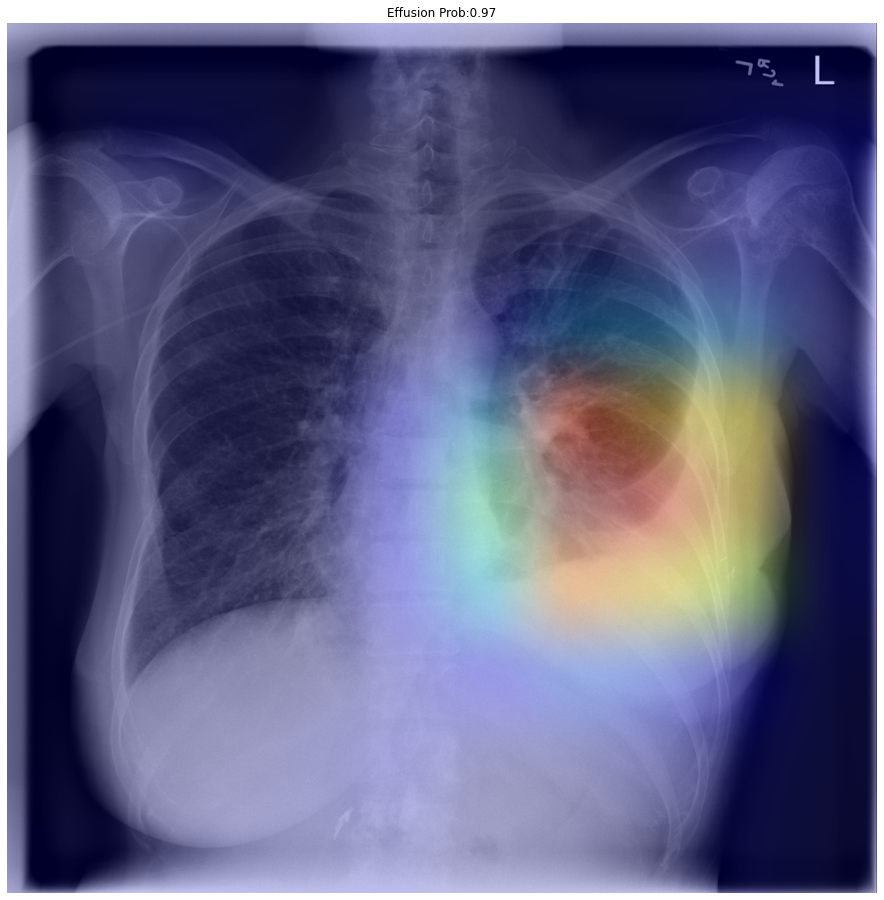

In [157]:
last_conv_layer_name = "relu"
classifier_layer_names = ["global_average_pooling2d", "dense"]
image_name = label_df.sample(n=1, axis=0).index[0]
img_array = load_preprocess(label_df,image_name)
heatmap, preds_tens = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, columns)
# We load the original image
img_path = os.path.join(IMAGE_PATH, image_name)
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

num_selections = 1 #Change this number if you want to see more of the top predictions
fig, axs = plt.subplots(num_selections, figsize = (16, 16))

max_index_list = []
max_prob_list = []
preds = np.array(preds_tens)

for index in range(num_selections):
    a = np.argmax(preds)
    max_index_list.append(a)
    max_prob_list.append(preds[0][a])
    preds[0][a] = 0

for counter, i in enumerate(max_index_list):
    # We rescale heatmap to a range 0-255
    heatmap_i = np.uint8(255 * heatmap[i])

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_i]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    if num_selections > 1:
        location = axs[counter]
    else:
        location = axs
        
    location.imshow(superimposed_img)
    location.set_title(columns[i]+ f" Prob:{max_prob_list[counter]:.2f}")
    location.axis('off')
    

plt.show()